In [37]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from econml.metalearners import SLearner, TLearner
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML, NonParamDML
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error 
import shap
from __future__ import annotations

Define Necessary Functions

In [38]:
#Split into train and test set
def get_split(simulation: pd.DataFrame) -> tuple[pd.DataFrame]:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]]
    T_train = train_df['T']
    Y_train = train_df['y']

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]]
    T_test = test_df['T']
    y_test = test_df['y']

    true_cate_test = test_df[['CATE', 'T']]

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [39]:
#Create OLS feature-treatment interactions
def get_ols_features(X_train: pd.DataFrame, T_train: pd.DataFrame, X_test: pd.DataFrame, T_test: pd.DataFrame) -> tuple[pd.DataFrame]:  

    interactions_train = pd.DataFrame()
    interactions_test = pd.DataFrame()


    for col in X_train.columns:
        interactions_train[f'{col}_T'] = X_train[col]*T_train
        interactions_test[f'{col}_T'] = X_test[col]*T_test


    X_train_ols = X_train.join(interactions_train)
    X_test_ols = X_test.join([interactions_test, pd.DataFrame(T_test, columns=['T'])])
    #X_test_ols.join(T)
    return X_train_ols, X_test_ols



In [40]:
def plot_predict_cate_corr(est_cate: np.array|pd.DataFrame, true_cate_test: np.array|pd.DataFrame):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(est_cate, true_cate_test, alpha=0.5)    
    plt.plot([min(true_cate_test), max(true_cate_test)], [min(true_cate_test), max(true_cate_test)], '--', color='red')
    plt.xlabel('Estimated CATE')
    plt.ylabel('True CATE')
    plt.grid(True)
    plt.show()

    if type(est_cate) == pd.DataFrame:
        reg = LinearRegression().fit(est_cate, true_cate_test)
    else:
        est_cate = est_cate.reshape(-1,1)
        reg = LinearRegression().fit(est_cate, true_cate_test)

    print(f'Correlation between true and predicted CATE: {reg.score(est_cate, true_cate_test)}')

Create Simulations

In [41]:
#Create simulations

sim_dict = {}

for p in [20, 50]:
    for n in [500, 1000, 5000]:
        sim: SimulationStudy = SimulationStudy(p=p, mean_correlation=0.5, cor_variance=0.05, n=n, no_feat_cate=10, non_linear=True)
        simulation = sim.create_dataset()


        key = f'Simulation_{p}_{n}'
        value = simulation

        sim_dict[key]= value


In [42]:
#from Gen_data import SimulationStudy
#sim: SimulationStudy = SimulationStudy(p=5, mean_correlation=0.5, cor_variance=0.05, n=10, no_feat_cate=5, non_linear=True)
#simulation = sim.create_dataset()

In [43]:
#Split df into train and test data

splits_dict = {}

for key, value in sim_dict.items():

    train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test = get_split(value)
    
    temp_dict = {'train_df': train_df, 'test_df': test_df, 
                   'X_train': X_train, 'Y_train': Y_train, 
                   'T_train': T_train, 'X_test': X_test, 
                   'T_test': T_test, 'Y_test': y_test, 
                   'true_cate_test': true_cate_test}

        
    splits_dict[key] = temp_dict



OLS Model

In [44]:
#Estimate a fully feature-treatment interacted model

x_train_ols, x_test_ols = get_ols_features(splits_dict['Simulation_20_5000']['X_train'], splits_dict['Simulation_20_5000']['T_train'],
                                            splits_dict['Simulation_20_5000']['X_test'], splits_dict['Simulation_20_5000']['T_test'])

In [45]:
def ols_estimator(x_train_ols: pd.DataFrame, y_train: pd.DataFrame, x_test_ols: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[pd.DataFrame, int]:

    #Create OLS object
    ols = LinearRegression()

    #Fit OLS 
    ols.fit(x_train_ols, y_train)

    #Estimate CATE
    x_test_ols = x_test_ols[x_test_ols['T']==1]
    x_test_ols = x_test_ols[[col for col in x_test_ols.columns if col.startswith('X') and col.endswith('T')]]
    
    coeff = pd.DataFrame(ols.coef_, x_train_ols.columns).T
    coeff = coeff[[col for col in coeff.columns if col.startswith('X') and col.endswith('T')]].T
    
    estimated_cate = x_test_ols.dot(coeff)
        
    #Calculate MSE
    true_cate_test = true_cate_test[true_cate_test['T'] == 1]
    true_cate_test = true_cate_test['CATE']

    OLS_MSE = mean_squared_error(true_cate_test, estimated_cate)

    return estimated_cate, OLS_MSE 
    

In [46]:
estimated_cate_ols, ols_MSE = ols_estimator(x_train_ols, splits_dict['Simulation_20_5000']['Y_train'], x_test_ols, splits_dict['Simulation_20_5000']['true_cate_test'])

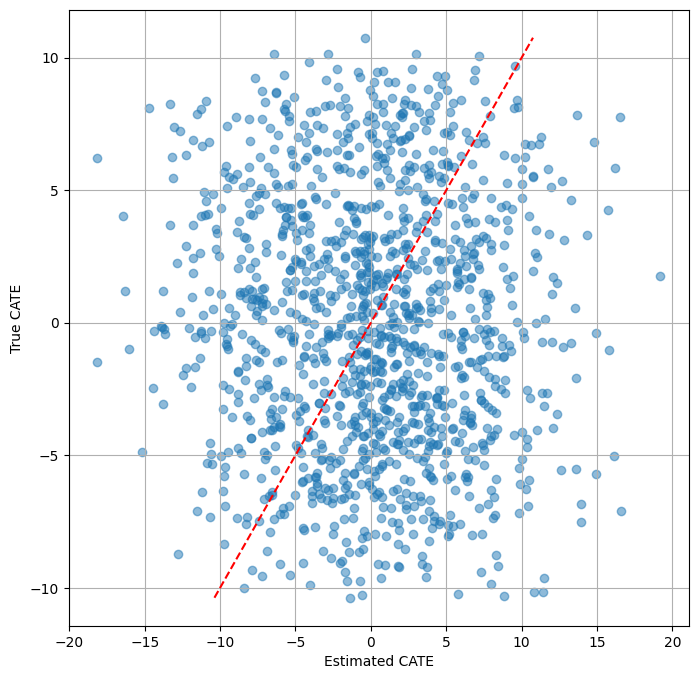

Correlation between true and predicted CATE: 0.0015232874276397412


In [47]:
true_cate_test = splits_dict['Simulation_20_5000']['true_cate_test']
true_cate_test = true_cate_test[true_cate_test['T'] == 1]
true_cate_test = true_cate_test['CATE']
plot_predict_cate_corr(estimated_cate_ols, true_cate_test)

T-Learner

In [48]:
def TLearner_estimator(Y_train: pd.DataFrame, T_train: pd.DataFrame, X_train: pd.DataFrame, X_test: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[np.ndarray, float]:

    Y_train = Y_train.to_numpy()
    T_train = T_train.to_numpy()
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    true_cate_test = true_cate_test['CATE'].to_numpy()
    
    est_t = TLearner(models=RandomForestRegressor())
    est_t.fit(Y=Y_train, T=T_train, X=X_train)
    estimated_cate_t = est_t.effect(X_test)
    T_MSE = mean_squared_error(true_cate_test, estimated_cate_t)

    return estimated_cate_t, T_MSE

estimated_cate_t, t_MSE = TLearner_estimator(splits_dict['Simulation_20_5000']['Y_train'], splits_dict['Simulation_20_5000']['T_train'], 
                                             splits_dict['Simulation_20_5000']['X_train'], splits_dict['Simulation_20_5000']['X_test'],
                                             splits_dict['Simulation_20_5000']['true_cate_test'])



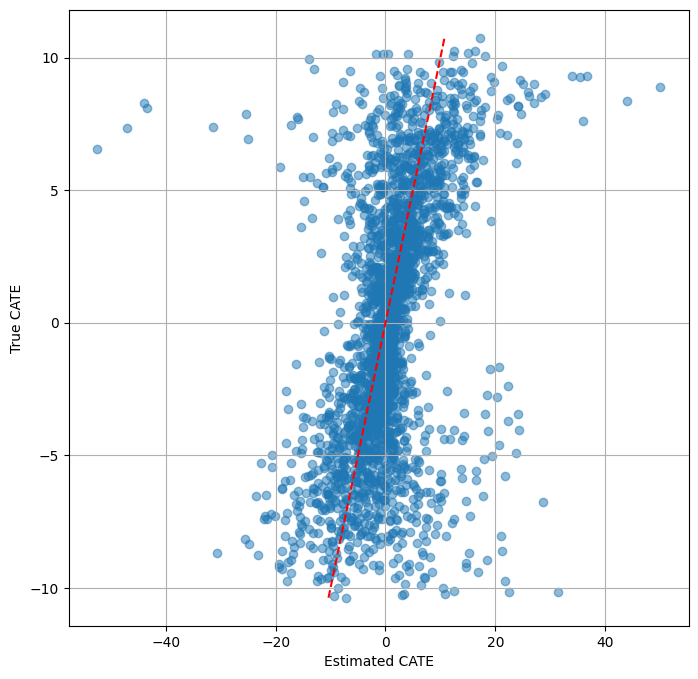

Correlation between true and predicted CATE: 0.1980865957538246


In [49]:
plot_predict_cate_corr(estimated_cate_t, splits_dict['Simulation_20_5000']['true_cate_test']['CATE'])

Causal Forest DML

In [50]:
def CF_DML(Y_train: pd.DataFrame, T_train: pd.DataFrame, X_train: pd.DataFrame, X_test: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[np.ndarray, float]:

    Y_train = Y_train.to_numpy()
    T_train = T_train.to_numpy()
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    true_cate_test = true_cate_test['CATE'].to_numpy()

#Estimate the causal forest model
    est_cfdml = CausalForestDML(model_y='auto',
                        model_t=DummyClassifier(),
                        discrete_treatment=True,
                        cv=5,
                        n_estimators=1000,
                        random_state=42,
                        criterion='mse',
                        honest=True)

    est_cfdml.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_cfdml.effect(X_test)
    mse = mean_squared_error(true_cate_test, estimated_cate)
    feat_imp = est_cfdml.feature_importances_
    
    return estimated_cate, mse, feat_imp

estimated_cate_dml, cf_dml_MSE, feat_imp = CF_DML(splits_dict['Simulation_20_5000']['Y_train'], splits_dict['Simulation_20_5000']['T_train'], 
                                       splits_dict['Simulation_20_5000']['X_train'], splits_dict['Simulation_20_5000']['X_test'],
                                       splits_dict['Simulation_20_5000']['true_cate_test'])



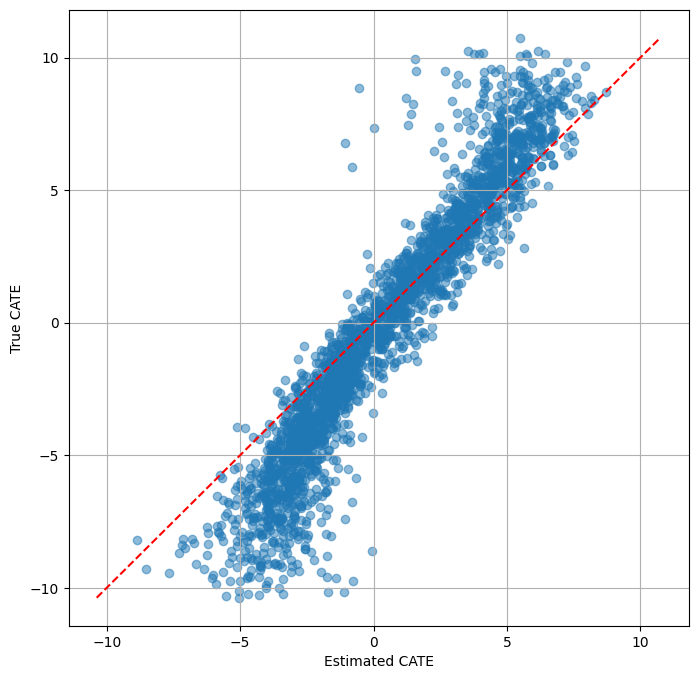

Correlation between true and predicted CATE: 0.9015177717246394


In [51]:
plot_predict_cate_corr(estimated_cate_dml, splits_dict['Simulation_20_5000']['true_cate_test']['CATE'])

In [52]:
feat_imp

array([0.08782263, 0.09654622, 0.11271921, 0.05031123, 0.08835194,
       0.06952582, 0.10876814, 0.0798949 , 0.08821567, 0.0581221 ,
       0.01518157, 0.01609023, 0.01414548, 0.01599471, 0.01032182,
       0.01545661, 0.01633499, 0.01320892, 0.03445863, 0.00852919])

Non-Parametric DML

In [54]:
def non_param_dml(Y_train: pd.DataFrame, T_train: pd.DataFrame, X_train: pd.DataFrame, X_test: pd.DataFrame, true_cate_test: pd.DataFrame) -> tuple[np.ndarray, float]:

    Y_train = Y_train.to_numpy()
    T_train = T_train.to_numpy()
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    true_cate_test = true_cate_test['CATE'].to_numpy()

    est_npm = NonParamDML(
        model_y='auto',
        model_t=DummyClassifier(),
        model_final=RandomForestRegressor(),
        cv = 5,
        random_state = 42,
        discrete_treatment=True,
    )
    
    est_npm.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_npm.effect(X_test)
    mse = mean_squared_error(true_cate_test, estimated_cate)

    return estimated_cate, mse

estimated_cate_non_param, non_param_MSE = non_param_dml(splits_dict['Simulation_20_5000']['Y_train'], splits_dict['Simulation_20_5000']['T_train'], 
                                       splits_dict['Simulation_20_5000']['X_train'], splits_dict['Simulation_20_5000']['X_test'],
                                       splits_dict['Simulation_20_5000']['true_cate_test'])



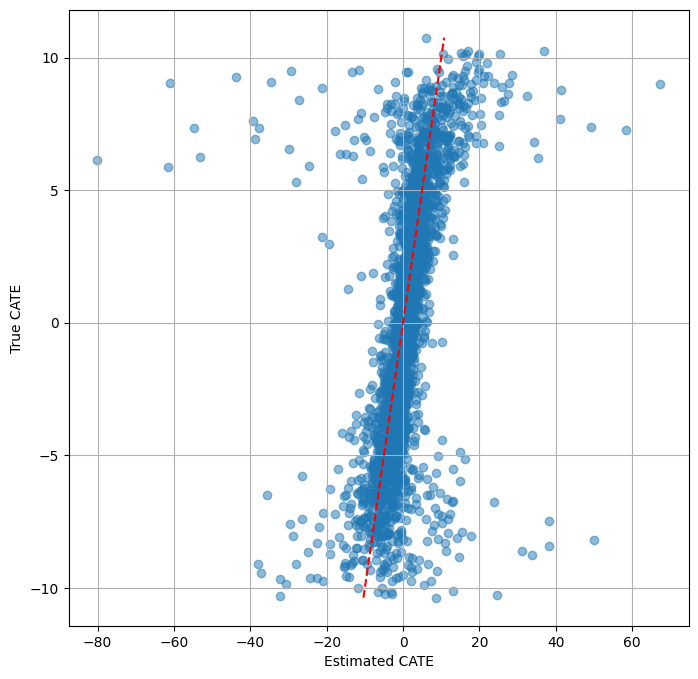

Correlation between true and predicted CATE: 0.22179281913700388


In [55]:
plot_predict_cate_corr(estimated_cate_non_param, splits_dict['Simulation_20_5000']['true_cate_test']['CATE'])

In [56]:
print(f'MSE OLS: {ols_MSE}')
print(f'MSE T-Learner: {t_MSE}')
print(f'MSE Double ML: {cf_dml_MSE}')
print(f'MSE Non-Parametric Double ML: {non_param_MSE}')

MSE OLS: 63.25102695576398
MSE T-Learner: 50.13859706398286
MSE Double ML: 4.351495818295484
MSE Non-Parametric Double ML: 51.801437846790016
